In [1]:
from scipy.sparse import coo_matrix
from sklearn.datasets import fetch_rcv1
from sklearn.utils import resample
from scipy.sparse import csr_matrix
from scipy.sparse import csc_matrix
from sklearn.datasets import fetch_openml
from scipy.io import arff
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import random
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score
import matplotlib

from sklearn.linear_model import Perceptron, LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit


# Data loading

In [26]:
rcv1 = fetch_rcv1()
X_reuters = rcv1.data
Y_reuters = rcv1.target[:, 89]
X_reuters = X_reuters>0
X_reuters = X_reuters.tocsc()
Y_reuters = Y_reuters.tocsc()


mnist = fetch_openml('mnist_784')
X_mnist = mnist.data.to_numpy()
Y_mnist = mnist.target.to_numpy().astype(int)
Y_mnist[Y_mnist != 6] = -1
Y_mnist[Y_mnist == 6] = 1


def fun(x):
    if type(x) == bytes:
        return str(x, encoding="utf-8")
    else:
        return x
data, meta = arff.loadarff("sonar.arff")
df = pd.DataFrame(data).applymap(fun).dropna()
X_sonar = df.iloc[:, 0:-1].to_numpy()
df.loc[df.Class == "Rock", "Class"] = -1
df.loc[df.Class == "Mine", "Class"] = 1
Y_sonar = np.array(df.iloc[:, -1].to_list())

# Utils

In [3]:
def calculateScores(clf, X_train, X_test, y_train, y_test, dataset_name):
    start = time.perf_counter()
    clf.fit(X_train, y_train)
    time_fit = time.perf_counter() - start

    y_pred = clf.predict(X_test)

    AUC_score = roc_auc_score(y_test, clf.decision_function(X_test))
    accuracy = accuracy_score(y_test, y_pred)
    F1_Score = f1_score(y_test, y_pred)

    to_append = [type(clf).__name__, dataset_name, learn, time_fit, accuracy, AUC_score, F1_Score]
    output = pd.Series(to_append, index=df.columns)
    return output

def splitData(X, Y, learn):
    
    if learn >= 0.1:
        X_train, X_test, y_train, y_test = train_test_split(X, Y, random_state=42, test_size=1-learn)
        return X_train, X_test, y_train, y_test 

    n_rows = X.shape[0]
    n_train = np.ceil((n_rows*learn)/2).astype(int)
    index_true = np.where(Y == 1)[0].astype(int)
    index_false = np.where(Y != 1)[0].astype(int)
    index_true = random.sample(list(index_true), n_train)
    index_false = random.sample(list(index_false), n_train)
    index_true.extend(index_false)

    all_indexes = np.array(range(n_rows))

    X_train = X[list(set(index_true))]
    X_test = X[np.setdiff1d(all_indexes, list(set(index_true)))]

    y_train = Y[list(set(index_true))]
    y_test = Y[np.setdiff1d(all_indexes, list(set(index_true)))]
        
    return X_train, X_test, y_train, y_test


# Main Loop

In [4]:
df = pd.DataFrame(columns=["model", "dataset", "learn", "fit_time", "AUC", "Accuracy", "F1_score"])
try:
    for learn in [0.001, 0.01, 0.02, 0.05, 0.1, 0.2, 0.3, 0.5]:
        print(f"Current learn: {learn}")
        X_train_sonar, X_test_sonar, y_train_sonar, y_test_sonar = splitData(X_sonar, Y_sonar, learn)
        X_train_reuters, X_test_reuters, y_train_reuters, y_test_reuters = splitData(X_reuters, Y_reuters.toarray().ravel(), learn)
        X_train_mnist, X_test_mnist, y_train_mnist, y_test_mnist = splitData(X_mnist, Y_mnist, learn)
        
        for _ in range(50):
            
            raise StopIteration
            
            # Sonar 
            clf = Perceptron(max_iter=1000)
            df = df.append(calculateScores(clf, X_train_sonar, X_test_sonar, y_train_sonar, y_test_sonar, "Sonar"), ignore_index=True)

            clf = LinearSVC(max_iter=1000)
            df = df.append(calculateScores(clf, X_train_sonar, X_test_sonar, y_train_sonar, y_test_sonar, "Sonar"), ignore_index=True)

            clf = LogisticRegression(max_iter=1000, solver="liblinear")
            df = df.append(calculateScores(clf, X_train_sonar, X_test_sonar, y_train_sonar, y_test_sonar, "Sonar"), ignore_index=True)


            # Reuters 
            clf = Perceptron(max_iter=1000)
            df = df.append(calculateScores(clf, X_train_reuters, X_test_reuters, y_train_reuters, y_test_reuters, "Reuters"), ignore_index=True)

            clf = LinearSVC(max_iter=1000)
            df = df.append(calculateScores(clf, X_train_reuters, X_test_reuters, y_train_reuters, y_test_reuters, "Reuters"), ignore_index=True)

            clf = LogisticRegression(max_iter=1000, solver="liblinear")
            df = df.append(calculateScores(clf, X_train_reuters, X_test_reuters, y_train_reuters, y_test_reuters, "Reuters"), ignore_index=True)


            # Mnist 
            clf = Perceptron(max_iter=1000)
            df = df.append(calculateScores(clf, X_train_mnist, X_test_mnist, y_train_mnist, y_test_mnist, "Mnist"), ignore_index=True)

            clf = LinearSVC(max_iter=1000)
            df = df.append(calculateScores(clf, X_train_mnist, X_test_mnist, y_train_mnist, y_test_mnist, "Mnist"), ignore_index=True)

            clf = LogisticRegression(max_iter=1000, solver="liblinear")
            df = df.append(calculateScores(clf, X_train_mnist, X_test_mnist, y_train_mnist, y_test_mnist, "Mnist"), ignore_index=True)
    
except StopIteration:
    pass

Current learn: 0.001


# Data Analysis

In [5]:
pd.set_option('display.max_rows', None)
df = pd.read_csv("Jakies.csv")

In [6]:
grouped = df.groupby(["dataset", "model", "learn"]).mean()
grouped

fit_time       AUC  Accuracy  F1_score
dataset model              learn                                         
Mnist   LinearSVC          0.001   0.002354  0.923067  0.984234  0.707771
                           0.010   0.019138  0.949019  0.989755  0.780545
                           0.020   0.085060  0.947377  0.987606  0.765913
                           0.050   0.174739  0.951150  0.987548  0.751400
                           0.100   0.196237  0.970843  0.987116  0.857689
                           0.200   0.636547  0.974288  0.987231  0.872649
                           0.300   1.565941  0.974266  0.987810  0.870101
                           0.500   3.658991  0.975102  0.989557  0.876022
        LogisticRegression 0.001   0.024555  0.925583  0.985568  0.715255
                           0.010   0.130584  0.949740  0.990316  0.783031
                           0.020   1.420380  0.952318  0.990193  0.784221
                           0.050   4.816333  0.955940  0.989183  0.770592
                           0.100   6.246114  0.972556  0.988260  0.865395
                           0.200  10.452253  0.969804  0.984823  0.854061
                           0.300  15.272778  0.977469  0.988761  0.889334
                           0.500  23.485595  0.983114  0.991892  0.916158
        Perceptron         0.001   0.001739  0.939740  0.981373  0.748868
                           0.010   0.014587  0.954242  0.990998  0.799342
                           0.020   0.062566  0.948936  0.988317  0.771360
                           0.050   0.192120  0.968286  0.990547  0.822639
                           0.100   0.249444  0.976254  0.989856  0.884586
                           0.200   0.487963  0.964821  0.991958  0.843502
                           0.300   0.504509  0.981939  0.991889  0.910651
                           0.500   0.656474  0.971057  0.992152  0.868595
Reuters LinearSVC          0.001   0.006292  0.934088  0.979769  0.534359
                           0.010   0.517292  0.948936  0.982562  0.571079
                           0.020   1.456064  0.949294  0.982451  0.537548
                           0.050   4.666617  0.948900  0.982700  0.377772
                           0.100   2.938471  0.977376  0.959004  0.719353
                           0.200   6.630860  0.976887  0.958517  0.715873
                           0.300  10.268800  0.976975  0.963326  0.718393
                           0.500  22.444002  0.977818  0.965460  0.726691
        LogisticRegression 0.001   0.391763  0.934704  0.980965  0.536982
                           0.010   0.946674  0.951079  0.985000  0.583063
                           0.020   1.837153  0.953732  0.986038  0.562252
                           0.050   5.545915  0.956321  0.987353  0.417967
                           0.100   5.250725  0.980125  0.977202  0.744953
                           0.200  15.065920  0.980697  0.978768  0.752688
                           0.300  27.120603  0.981133  0.982352  0.758820
                           0.500  61.739213  0.981833  0.984027  0.767345
        Perceptron         0.001   0.005591  0.911247  0.971388  0.460038
                           0.010   0.090511  0.939744  0.978076  0.530589
                           0.020   0.237803  0.942848  0.979703  0.508927
                           0.050   0.938460  0.953436  0.979644  0.397412
                           0.100   1.097337  0.977170  0.935943  0.703363
                           0.200   3.843564  0.976429  0.946685  0.704682
                           0.300   8.485112  0.976389  0.957282  0.713797
                           0.500  12.244435  0.975714  0.966149  0.724037
Sonar   LinearSVC          0.001   0.000389  0.574951  0.653030  0.641788
                           0.010   0.000482  0.544118  0.541864  0.620408
                           0.020   0.000549  0.638614  0.675236  0.654028
                           0.050   0.000676  0.586735  0.663108  0.630137
                           0.100   0.00

# Sonar

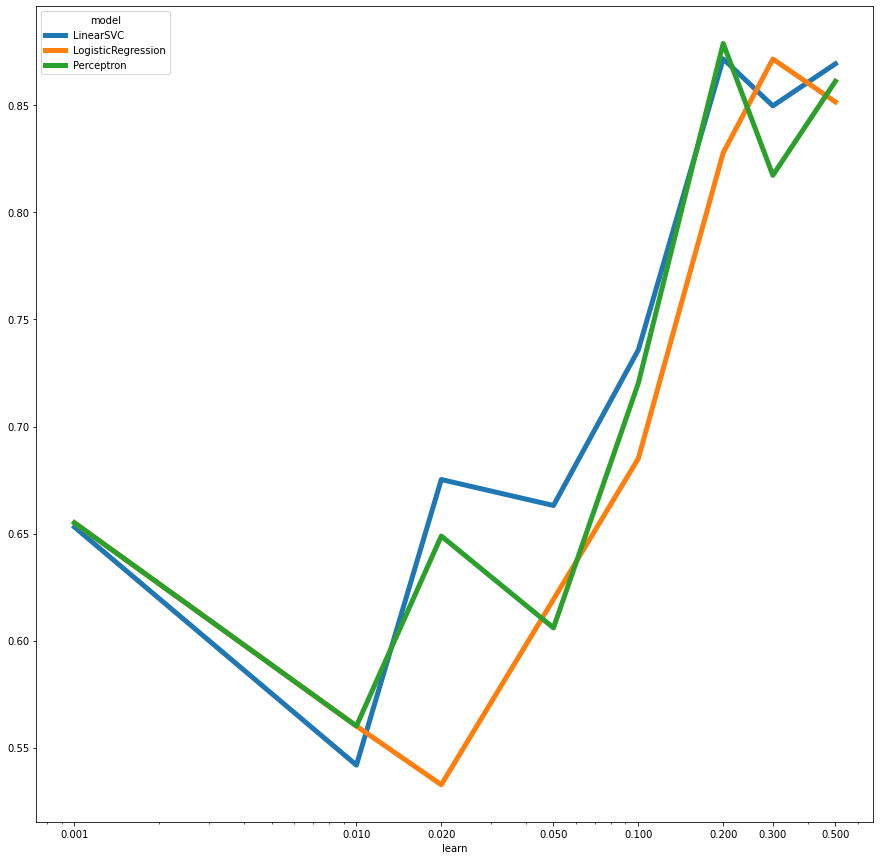

In [7]:
fig = plt.figure(figsize=(15, 15))
ax = fig.add_subplot(111)
df.loc[(df["dataset"] == "Sonar")].groupby(["model", "learn"])["Accuracy"].mean().unstack("model").plot(legend=True, linewidth=5, ax=ax)
ax.set_xscale("log")
ax.set_xticks([0.001, 0.01, 0.02, 0.05, 0.1, 0.2, 0.3, 0.5])
ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
plt.show()

# Reuters

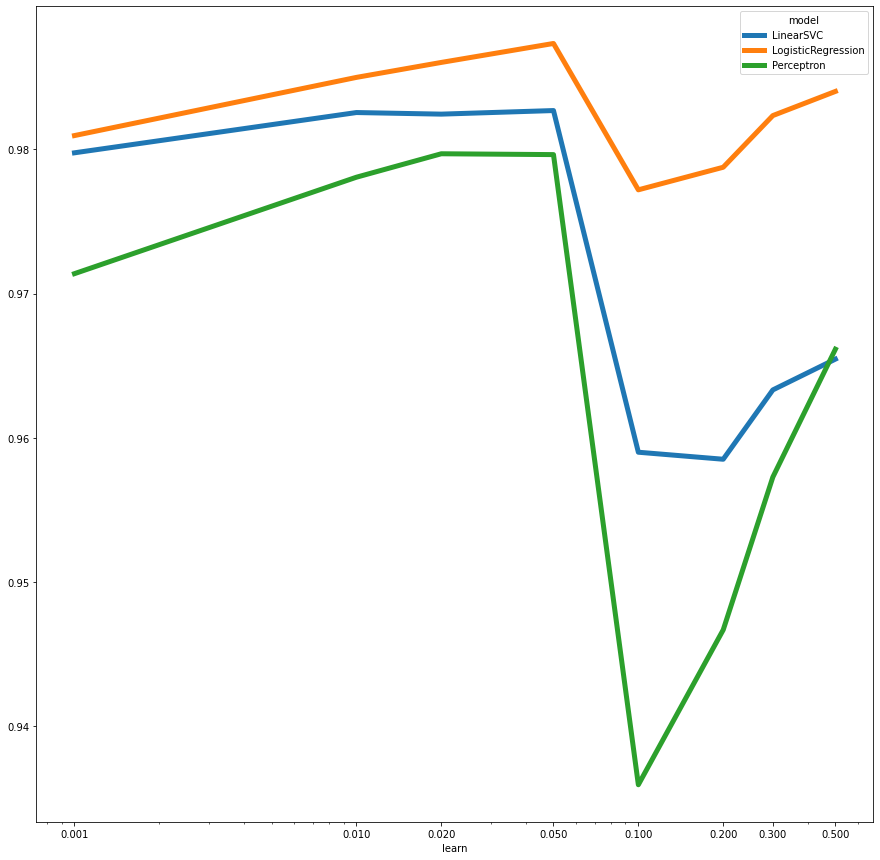

In [8]:
fig = plt.figure(figsize=(15, 15))
ax = fig.add_subplot(111)
df.loc[(df["dataset"] == "Reuters")].groupby(["model", "learn"])["Accuracy"].mean().unstack("model").plot(legend=True, linewidth=5, ax=ax)
ax.set_xscale("log")
ax.set_xticks([0.001, 0.01, 0.02, 0.05, 0.1, 0.2, 0.3, 0.5])
ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
plt.show()

# Mnist

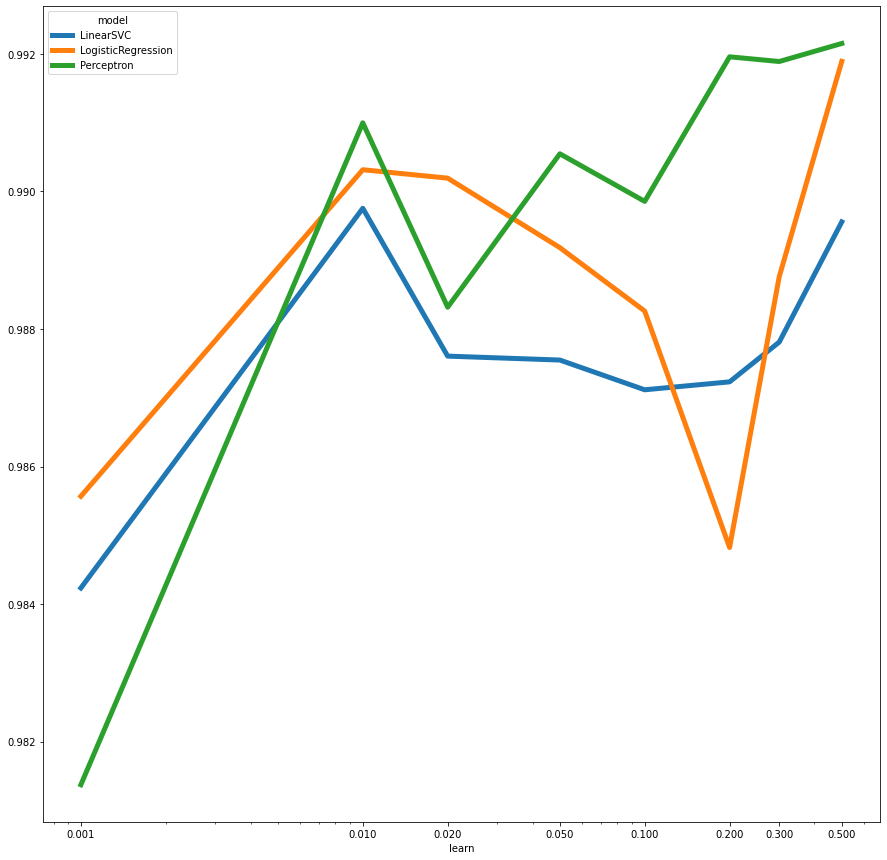

In [9]:
fig = plt.figure(figsize=(15, 15))
ax = fig.add_subplot(111)
df.loc[(df["dataset"] == "Mnist")].groupby(["model", "learn"])["Accuracy"].mean().unstack("model").plot(legend=True, linewidth=5, ax=ax)
ax.set_xscale("log")
ax.set_xticks([0.001, 0.01, 0.02, 0.05, 0.1, 0.2, 0.3, 0.5])
ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
plt.show()

# Reuters - Logistic Regression

In [50]:
clf = LogisticRegression(max_iter=1000, penalty="l1", solver="liblinear")
clf.fit(X_reuters, Y_reuters.toarray().ravel())

LogisticRegression(max_iter=1000, penalty='l1', solver='liblinear')

In [51]:
labels = pd.read_csv("stem.termid.idf.map.txt", sep=" ", header=None)

In [52]:
np.save("coef.npy", clf.coef_[0])

In [53]:
coef = np.load("coef.npy")

In [58]:
dictionary = {k:v for k, v in zip(list(labels.iloc[:, 0]), list(coef))}

In [59]:
sorted_dict = dict(sorted(dictionary.items(),
                           key=lambda item: item[1],
                           reverse=False))

list(sorted_dict.items())[:20]

[('celtic', -4.4309952352229125),
 ('digest', -4.326049403520806),
 ('vittorio', -4.292146230424151),
 ('statelet', -4.001283035586997),
 ('nat', -3.9285637873634807),
 ('stillborn', -3.7697589718227884),
 ('trabzon', -3.727243229113435),
 ('speer', -3.635759942388736),
 ('gurkh', -3.558773720941757),
 ('sharpevill', -3.486136574904095),
 ('monroe', -3.46283767722013),
 ('yangtz', -3.372171678041517),
 ('serzh', -3.3137192940227465),
 ('bandido', -3.223815729775068),
 ('diatrib', -3.011149150259691),
 ('valparais', -3.0079929698047536),
 ('clubhous', -2.9559192960582945),
 ('kharj', -2.9179107530379027),
 ('swe', -2.9131846391734593),
 ('hiroshim', -2.9100862777786567)]

In [60]:
sorted_dict = dict(sorted(dictionary.items(),
                           key=lambda item: item[1],
                           reverse=True))

list(sorted_dict.items())[:20]

[('manufactu', 4.294013452274445),
 ('salvoe', 4.068705880991433),
 ('mahlich', 3.839640522237986),
 ('frii', 3.5114489487603078),
 ('pricewatch', 3.4990825088589195),
 ('homlaor', 3.4355151134488384),
 ('mehrabad', 3.423646605907668),
 ('corneliu', 3.4163646714737594),
 ('signifig', 3.315719264029869),
 ('cbm', 3.195313783120286),
 ('pantoj', 3.185022985246222),
 ('underpopul', 3.177602975516021),
 ('airrep', 3.169616694624599),
 ('reasur', 3.102623213660285),
 ('megac', 3.0082271366609072),
 ('seing', 2.9914379046706534),
 ('chalon', 2.9325765810345814),
 ('m5', 2.8288375123995024),
 ('gottfr', 2.8021869585872885),
 ('nsdap', 2.801850908310922)]